# Producing SimulPS txt files to use NLLoc on a 3D velocity model

This notebook produces the text files needed for Vel2Grid3D based on Trugman, 2024, to use the Savard velocity model for travel-time grids (Loïc 1+2+3 notebooks + mine VelModel_NLLoc). *Notes at the end on the differences.*

Watch out for !!, TO-DO, ###.

NB: VelModel_NLLoc.ipynb creates the .netdcf version of the velocity model used it. It has to be run **before**.

In [34]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
from scipy import interpolate
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
from scipy.interpolate import griddata
base_dir = '/Users/lpapin/Documents/phd/projects/sw4/nonlinloc/'

## Definition of the polygon

### Create the json file

In [2]:
# Functions to create the polygon of the subset for projection
def write_json(new_data, filename='svi_poly.json'):
    with open(filename, 'w') as file:
        json.dump([], file)
    with open(filename, 'r+') as file:
        file_data = file.read().strip()
        if file_data == '':
            file_data = []
        else:
            file_data = json.loads(file_data)
        file_data.append(new_data)
        file.seek(0)
        json.dump(file_data, file, indent=4)

def create_dict_std_param(poly_id, min_lon, max_lon, min_lat, max_lat):
    dictionary = {
        "poly_id": poly_id,
        "olon": (min_lon + max_lon) / 2,
        "olat": (min_lat + max_lat) / 2,
        "plat1": min_lat,
        "plat2": max_lat,
        "xmin": -55.0,
        "xmax": 55.0,
        "xsep": 1.0,
        "ymin": -72.5,
        "ymax": 72.5,
        "ysep": 1.0,
        "zmin": -1.0,
        "zmax": 93.0,
        "zsep": 1.0,
        "minlon": min_lon,
        "maxlon": max_lon,
        "minlat": min_lat,
        "maxlat": max_lat,
    }
    return dictionary
print("The boundaries of the Cartesian project are defined arbitrary with the lat/lon limits")
print("!! needs to be changed for a different polygon (see VelModel_NLLoc.ipynb)")

The boundaries of the Cartesian project are defined arbitrary with the lat/lon limits
!! needs to be changed for a different polygon (see VelModel_NLLoc.ipynb)


In [3]:
# Define the limits of the subset (defined previously in VelModel_NLLoc.ipynb)
latMin, latMax, lonMin, lonMax = 48, 49.3, -124.5, -123

# Only the subset region
rectangles = [[1, lonMin, latMin, lonMax, latMax]]
subset_polygon = pd.DataFrame(rectangles, columns=['poly_id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'])

# Write the json file
for i, row in subset_polygon.iterrows():
    write_json(create_dict_std_param(row.poly_id, row.min_lon, row.max_lon, row.min_lat, row.max_lat))

with open("svi_poly.json", 'r') as file:
    polygon = json.load(file)

# Velocity model subset parameters
polygon[0]

{'poly_id': 1.0,
 'olon': -123.75,
 'olat': 48.65,
 'plat1': 48.0,
 'plat2': 49.3,
 'xmin': -55.0,
 'xmax': 55.0,
 'xsep': 1.0,
 'ymin': -72.5,
 'ymax': 72.5,
 'ysep': 1.0,
 'zmin': -1.0,
 'zmax': 93.0,
 'zsep': 1.0,
 'minlon': -124.5,
 'maxlon': -123.0,
 'minlat': 48.0,
 'maxlat': 49.3}

## Projection of the model on the polygon (degrees to km)

This part define the parameters of the projection to transform the coordinates in lon and lat of the stations, the events, and the velocity model in km, and execute the projection.

### Parameters of the projection

In [4]:
# Parameters for projection (kept the original lines in case later multiple polygons)
poly = 1
pproj = "lcc" # "tmerc"
poly_param = polygon[poly-1]

# Origin for pyproj projection
olat, olon = poly_param['olat'], poly_param['olon']

# Projection lcc only
plat1, plat2 = poly_param['plat1'], poly_param['plat2']

# Cartesian grid bounds for velocity model
xmin, xmax, xsep = poly_param['xmin'], poly_param['xmax'], poly_param['xsep']
ymin, ymax, ysep = poly_param['ymin'], poly_param['ymax'], poly_param['ysep']
zmin, zmax, zsep = poly_param['zmin'], poly_param['zmax'], poly_param['zsep']

In [5]:
# Projection setup
crs1 = CRS.from_proj4("+proj=longlat +ellps=WGS84")
if pproj == "lcc":
    crs2 = CRS.from_proj4("+proj={:} +ellps=WGS84 +lat_0={:.4f} +lon_0={:.4f} +lat_1={:.4f} +lon_2={:.4f} +units=km".format(
        pproj,olat,olon,plat1,plat2))
else:
    crs2 = CRS.from_proj4("+proj={:} +ellps=WGS84 +lat_0={:.4f} +lon_0={:.4f} +units=km".format(
        pproj,olat,olon))

# From lat/lon to km et inversement
proj = Transformer.from_crs(crs1,crs2)
iproj = Transformer.from_crs(crs2,crs1)

### Project the stations

The stations have been choosen so it already fits in the subset, if changes are made for boundaries or stations, it is better to check that the stations fits in the rectangle.

In [6]:
# Load the stations
stas=pd.read_csv('stations.csv', usecols=[0, 1, 2, 3, 4],
                    names=['net', 'sta', 'lat', 'lon', 'elev'], header=0, delimiter='|')
# Matching the stations with the one used in the picker
stations_to_keep = {'SSIB', 'SILB', 'TSJB', 'TWKB', 'KLNB', 'LZB', 'PGC', 'PFB', 'MGCB', 'NLLB', 'SNB', 'YOUB'}
stas = stas[stas['sta'].isin(stations_to_keep)].reset_index(drop=True)
print(stas['sta'].to_list())

['MGCB', 'LZB', 'NLLB', 'PFB', 'PGC', 'SNB', 'YOUB', 'KLNB', 'SILB', 'SSIB', 'TSJB', 'TWKB']


In [7]:
# Find the boundaries for projection
staslat0, staslat1 = stas['lat'].min(), stas['lat'].max()
staslon0, staslon1 = stas['lon'].min(), stas['lon'].max()
staselv0, staselv1 = stas['elev'].min(), stas['elev'].max()
print(f"Minimum longitude: {staslon0:.3f}, maximum longitude: {staslon1:.3f}")
print(f"Minimum latitude: {staslat0:.3f}, maximum latitude: {staslat1:.3f}")
print(f"Minimum elevation: {staselv0:.0f}, maximum elevation: {staselv1:.0f}")

Minimum longitude: -124.454, maximum longitude: -123.172
Minimum latitude: 48.575, maximum latitude: 49.227
Minimum elevation: 0, maximum elevation: 794


In [8]:
# Find the center point
staslonC, staslatC = np.round(0.5*(staslon0+staslon1),4), np.round(0.5*(staslat0+staslat1),4)
print(f"Center point lon: {staslonC:.3f}, lat: {staslatC:.3f}")

Center point lon: -123.813, lat: 48.901


In [9]:
# New coordinates with projection
stasxproj, stasyproj = proj.transform(stas['lon'], stas['lat'])
stas['x'] = stasxproj
stas['y'] = stasyproj
print(f"x min: {stas['x'].min():.3f}, x max: {stas['x'].max():.3f}")
print(f"y min: {stas['y'].min():.3f}, y max: {stas['y'].max():.3f}")

x min: -51.959, x max: 42.465
y min: -8.137, y max: 64.214


In [10]:
# How it looks
stas

,net,sta,lat,lon,elev,x,y
0,C8,MGCB,48.6317,-123.6808,236.0,5.101026,-2.032849
1,CN,LZB,48.6122,-123.8240,794.0,-5.456936,-4.201094
2,CN,NLLB,49.2271,-123.9882,199.0,-17.354113,64.214175
3,CN,PFB,48.5747,-124.4541,449.0,-51.959380,-8.136748
4,CN,PGC,48.6498,-123.4521,12.0,21.951647,0.020167
5,CN,SNB,48.7751,-123.1723,402.0,42.464836,14.071816
6,CN,YOUB,48.9010,-124.2618,771.0,-37.527868,28.039696
7,PO,KLNB,48.6611,-123.5706,0.0,13.216719,1.249812
8,PO,SILB,48.6020,-123.2815,76.0,34.554990,-5.233050
9,PO,SSIB,48.7558,-123.3875,12.0,26.656432,11.828935


In [11]:
# Write the stations file for GTSOURCE command
with open('stations_coords_svi.txt', 'w') as f:
    f.write("#GTSRCE  label  type    xSrce      ySrce      zSrce  elev\n")
    for _, row in stas.iterrows():
        line = f"GTSRCE  {row['sta']}  XYZ  {row['x']:.6f}  {row['y']:.6f}  0  {row['elev']/1000:.4f}\n"
        f.write(line)
print("Data written to stations_coords_svi.txt")

Data written to stations_coords_svi.txt


### Project the events

Same thing as for the stations, the events actually made the boundaries of the rectangle (VelModel_NLLoc.ipynb) so if any changes are made, a filter can be added to keep only the events of the region.

In [12]:
# Prepare the events
events = pd.read_csv('lfe_svi.txt', index_col=0, dtype={'date': str, 'hour': str, 'lfe_family': str})
events['date'] = '20' + events['date']
events['date'] = pd.to_datetime(events['date'], format='%Y%m%d')
events['hour'] = events['hour'].str.zfill(2)
events['OT'] = events['date'] + pd.to_timedelta(events['hour'].astype(int), unit='h') + pd.to_timedelta(events['second'], unit='s')
events = events.drop(columns=['hour', 'second'])
events = events.sort_values(by='OT', ascending=True)
events.reset_index(inplace=True)
events.index.name = 'Index'

In [13]:
# Load the locations
sav_family_phases = np.load('sav_family_phases.npy', allow_pickle=True).item()

# Get the families and match the locations
nb_family = events['lfe_family'].unique()
nb_family.sort()
eventLocs = []
for fam in nb_family:
    eqLoc_values = sav_family_phases[fam]['eqLoc']
    lon_family, lat_family, z_family = eqLoc_values
    lon_family = lon_family * -1
    eventLocs.append([fam, lon_family, lat_family, z_family])
eventLocs = pd.DataFrame(eventLocs, columns=['Index', 'lon', 'lat', 'depth'])
eventLocs.set_index('Index', inplace=True)  # Set family as index

# Merge events with eventLocs on 'lfe_family' and 'Index'
merged_events = events.merge(eventLocs, how='left', left_on='lfe_family', right_index=True)
merged_events

,lfe_family,date,Mw,OT,lon,lat,depth
Index,,,,,,,
0,045,2003-02-26,1.513,2003-02-26 00:15:02.050,-123.864833,48.349667,31.32
1,132,2003-02-26,1.516,2003-02-26 00:49:42.850,-123.890000,48.308000,29.89
2,032,2003-02-26,1.516,2003-02-26 01:27:25.575,-123.787167,48.179167,29.60
3,032,2003-02-26,1.583,2003-02-26 01:28:08.375,-123.787167,48.179167,29.60
4,066,2003-02-26,1.850,2003-02-26 01:47:36.225,-123.834667,48.196833,29.51
...,...,...,...,...,...,...,...
269418,078,2013-10-13,1.150,2013-10-13 14:30:58.400,-123.878833,48.712500,39.75
269419,275,2013-10-13,1.352,2013-10-13 15:01:46.800,-123.893833,48.880167,39.91
269420,263,2013-10-13,1.360,2013-10-13 15:04:50.000,-123.322333,48.444667,38.82


In [14]:
# Find the boundaries for projection
events = merged_events
eventslon0, eventslon1 = events['lon'].quantile([0,1]).values
eventslat0, eventslat1 = events['lat'].quantile([0,1]).values
eventslonM, eventslatM = (eventslon0+eventslon1)/2, (eventslat0+eventslat1)/2
print(f"Middle longitude: {eventslonM}")
print(f"Middle latitude: {eventslatM}")

Middle longitude: -123.7195
Middle latitude: 48.52466666666666


In [15]:
# New coordinates with projection
eventsxproj, eventsyproj = proj.transform(events['lon'],events['lat'])
events['x'] = eventsxproj
events['y'] = eventsyproj

# Useful for NonLinLoc
print("Projected seismicity bounds:")
print(f"x min: {events['x'].min():.3f}, x max: {events['x'].max():.3f}")
print(f"y min: {events['y'].min():.3f}, y max: {events['y'].max():.3f}")

Projected seismicity bounds:
x min: -43.280, x max: 48.148
y min: -59.028, y max: 31.245


In [16]:
# How it looks
events

,lfe_family,date,Mw,OT,lon,lat,depth,x,y
Index,,,,,,,,,
0,045,2003-02-26,1.513,2003-02-26 00:15:02.050,-123.864833,48.349667,31.32,-8.511565,-33.392049
1,132,2003-02-26,1.516,2003-02-26 00:49:42.850,-123.890000,48.308000,29.89,-10.385355,-38.022231
2,032,2003-02-26,1.516,2003-02-26 01:27:25.575,-123.787167,48.179167,29.60,-2.763972,-52.356756
3,032,2003-02-26,1.583,2003-02-26 01:28:08.375,-123.787167,48.179167,29.60,-2.763972,-52.356756
4,066,2003-02-26,1.850,2003-02-26 01:47:36.225,-123.834667,48.196833,29.51,-6.294244,-50.389529
...,...,...,...,...,...,...,...,...,...
269418,078,2013-10-13,1.150,2013-10-13 14:30:58.400,-123.878833,48.712500,39.75,-9.481834,6.958637
269419,275,2013-10-13,1.352,2013-10-13 15:01:46.800,-123.893833,48.880167,39.91,-10.551011,25.607873
269420,263,2013-10-13,1.360,2013-10-13 15:04:50.000,-123.322333,48.444667,38.82,31.640343,-22.746564


### Load the velocity model in netdcf + examples

In [17]:
# Load the xarray
velocities = xr.open_dataset("velmodel_interp.nc")
velocities

<xarray.Dataset> Size: 119MB
Dimensions:    (lon: 1156, depth: 95, lat: 34)
Coordinates:
  * lon        (lon) float64 9kB -126.8 -126.8 -126.8 ... -120.5 -120.5 -120.5
  * depth      (depth) int32 380B -1 0 1 2 3 4 5 6 7 ... 86 87 88 89 90 91 92 93
  * lat        (lat) float64 272B 46.95 47.08 47.2 47.32 ... 50.74 50.86 50.99
Data variables:
    vp_interp  (depth, lat, lon) float64 30MB ...
    vs_interp  (depth, lat, lon) float64 30MB ...
    vp         (lat, lon, depth) float64 30MB ...
    vs         (lat, lon, depth) float64 30MB ...

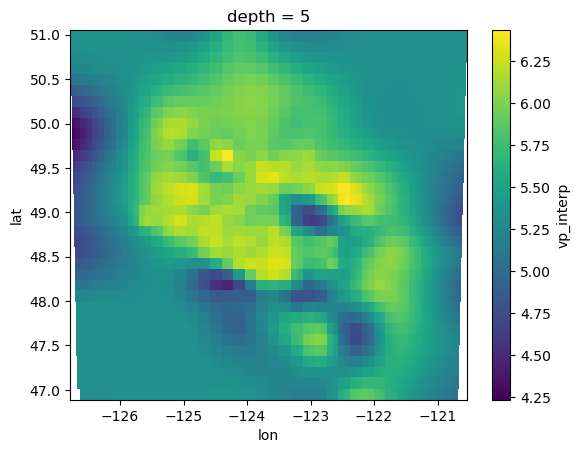

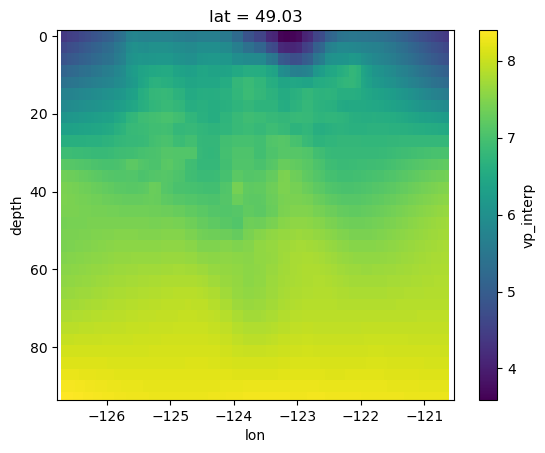

In [65]:
# Plot a fixed depth example
velocities['vp_interp'].sel(depth = 5).plot()
plt.show()

# Plot a fixed latitude example
velocities['vp_interp'].sel(lat = (velocities.lat.min().data + velocities.lat.max().data)/2, method='nearest').plot(y = 'depth')
plt.gca().invert_yaxis()
plt.show()

### Project the grid and the velocities

In [20]:
# Create a grid with Cartesian coordinates
xgrid, ygrid = np.meshgrid(
    np.arange(xmin,xmax+xsep/2,xsep),
    np.arange(ymin,ymax+ysep/2,ysep))

# Projection in lat/lon of the grid
lon_grid, lat_grid = iproj.transform(xgrid,ygrid)

# Is the projection good?
print(f'Should match approximately {lonMin:.2f}, {lonMax:.2f}, {latMin:.2f}, {latMax:.2f}')
print(f'{lon_grid[0][0]:.2f},{lon_grid[-1][-1]:.2f}')
print(f'{lat_grid[0][0]:.2f},{lat_grid[-1][-1]:.2f}')

Should match approximately -124.50, -123.00, 48.00, 49.30
-124.49,-122.99
48.00,49.30


In [21]:
# Output grid
x_flat, y_flat = np.ravel(xgrid), np.ravel(ygrid)
out_lonflat, out_latflat = np.ravel(lon_grid), np.ravel(lat_grid)

# Original velocity model
longrid, latgrid = np.meshgrid(
    np.asarray(velocities.lon), np.asarray(velocities.lat))
vel_lonflat = np.ravel(longrid)
vel_latflat = np.ravel(latgrid)

In [22]:
# Velocities interpolation on depths
out_obs = np.vstack([out_lonflat, out_latflat]).T
vel_obs = np.vstack([vel_lonflat, vel_latflat]).T
xvals, yvals, zvals, vpvals, vsvals = [], [], [], [], []
for z in velocities['depth'].values:
    vel_vp = np.ravel(velocities['vp_interp'].interp(depth = z, method = 'linear').values)
    vel_vs = np.ravel(velocities['vs_interp'].interp(depth = z, method = 'linear').values)
    # Interpolation process
    out_vp = interpolate.griddata(vel_obs, vel_vp, out_obs, method="linear")
    out_vs = interpolate.griddata(vel_obs, vel_vs, out_obs, method="linear")
    # Update the values
    xvals.append(x_flat)
    yvals.append(y_flat)
    zvals.append(z + np.zeros(y_flat.size))
    vpvals.append(out_vp) # km/s
    vsvals.append(out_vs) # km/s
    # Progress
    if np.mod(z,10.0) < 0.1: print(f"Done with depth {z:0.1f}")

Done with depth 0.0
Done with depth 10.0
Done with depth 20.0
Done with depth 30.0
Done with depth 40.0
Done with depth 50.0
Done with depth 60.0
Done with depth 70.0
Done with depth 80.0
Done with depth 90.0


In [23]:
# Make a DataFrame
odf = pd.DataFrame({
    "x": np.hstack(xvals),
    "y": np.hstack(yvals),
    "z": np.hstack(zvals),
    "vp": np.hstack(vpvals),
    "vs": np.hstack(vsvals),
})

# Grid points
xg = odf["x"].unique()
yg = odf["y"].unique()
zg = odf["z"].unique()
nx, ny, nz = len(xg), len(yg), len(zg)
print('Values :',nx,'lon,',ny,'lat,', nz, 'depth')

# How it looks ###ok
odf

Values : 111 lon, 146 lat, 95 depth


,x,y,z,vp,vs
0,-55.0,-72.5,-1.0,4.251633,2.457620
1,-54.0,-72.5,-1.0,4.239884,2.450830
2,-53.0,-72.5,-1.0,4.227822,2.443856
3,-52.0,-72.5,-1.0,4.215767,2.436885
4,-51.0,-72.5,-1.0,4.203717,2.429918
...,...,...,...,...,...
1539565,51.0,72.5,93.0,8.307535,4.801899
1539566,52.0,72.5,93.0,8.306974,4.801563
1539567,53.0,72.5,93.0,8.306443,4.801245
1539568,54.0,72.5,93.0,8.305890,4.800915


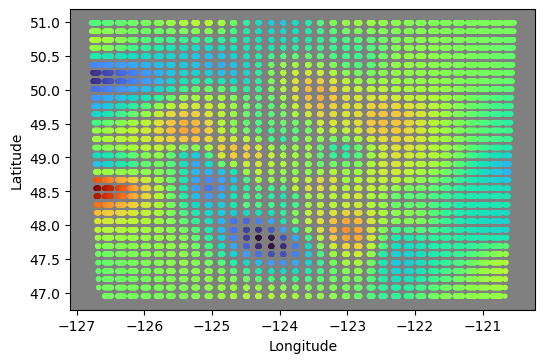

In [24]:
# Check to see how the velocities interpolated
test_depth = 35.0
data = velocities["vs_interp"].interp(depth = test_depth, method = "linear") # If depth value doesn't exist
lons = np.asarray(data.lon)
lats = np.asarray(data.lat)
mx, my = np.meshgrid(lons,lats)
fx, fy = np.ravel(mx), np.ravel(my)
md = np.ravel(data.values)

# Plot the results in lat/lon
fig, axi = plt.subplots(figsize=(6,6))
axi.set_aspect("equal")
axi.set_facecolor("gray")
axi.scatter(fx,fy,s=8,c=md,cmap=plt.cm.turbo_r)
axi.set_xlabel("Longitude")
axi.set_ylabel("Latitude")
plt.show()

In [25]:
# Function to fill NaN values using nearest neighbors
def fill_nan_with_nearest_neighbors(df, columns):
    for z_val in df['z'].unique():
        subset = df[df['z'] == z_val]
        for col in columns:
            mask = subset[col].notna()
            points = subset[mask][['x', 'y']].values
            values = subset[mask][col].values
            grid = subset[['x', 'y']].values
            filled_values = interpolate.griddata(points, values, grid, method='nearest')
            df.loc[df['z'] == z_val, col] = filled_values
    return df

In [26]:
# Fill NaN values for vp and vs
odf = fill_nan_with_nearest_neighbors(odf, ['vp', 'vs'])
if not odf[['vp', 'vs']].isna().any().any():
    print('NaN disappeared!')
odf

NaN disappeared!


,x,y,z,vp,vs
0,-55.0,-72.5,-1.0,4.251633,2.457620
1,-54.0,-72.5,-1.0,4.239884,2.450830
2,-53.0,-72.5,-1.0,4.227822,2.443856
3,-52.0,-72.5,-1.0,4.215767,2.436885
4,-51.0,-72.5,-1.0,4.203717,2.429918
...,...,...,...,...,...
1539565,51.0,72.5,93.0,8.307535,4.801899
1539566,52.0,72.5,93.0,8.306974,4.801563
1539567,53.0,72.5,93.0,8.306443,4.801245
1539568,54.0,72.5,93.0,8.305890,4.800915


#### Checking the projection in km with plots

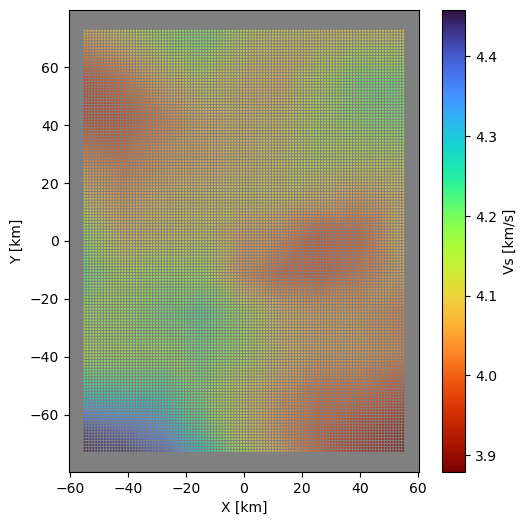

In [27]:
# Plot the results in km
test_depth = 35.0
zdf = odf.groupby("z").get_group(test_depth)
fig, axi = plt.subplots(figsize=(6,6))
axi.set_aspect("equal")
axi.set_facecolor("gray")
sc = axi.scatter(zdf["x"],zdf["y"],s=0.15,c=zdf["vs"],
            cmap=plt.cm.turbo_r)
axi.set_xlabel("X [km]")
axi.set_ylabel("Y [km]")
cbar = fig.colorbar(sc, ax=axi)
cbar.set_label("Vs [km/s]")
plt.show()

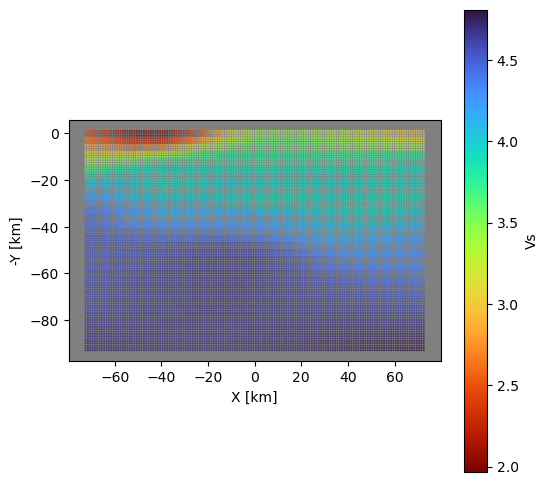

In [29]:
# select data from dataframe 
zdf = odf.groupby("x").get_group(-55.0)

# now plot results to check
fig, axi = plt.subplots(figsize=(6,6))
axi.set_aspect("equal")
axi.set_facecolor("gray")
scatter = axi.scatter(zdf["y"],-zdf["z"],s=0.15,c=zdf["vs"],
            cmap=plt.cm.turbo_r)
cbar = fig.colorbar(scatter, ax=axi)
cbar.set_label("Vs")
axi.set_xlabel("X [km]")
axi.set_ylabel("-Y [km]")
plt.show()

It seems than in the SVI case I don't have much NaN values so no big changes.

## Write the SimulPS.txt files

In [30]:
# Filename for local; will go in the model folder later
output_filename_P=f'Savard_{pproj}_P.txt'
with open(output_filename_P,"w") as f:
    
    # Header line
    unit, nph = 1.0, 2 # grid units are 1km, 2 phases
    f.writelines("%f %d %d %d %d # SimulPS P-wave Model\n" %(unit,nx,ny,nz,nph))
    
    # Write xgrid, ygrid, zgrid
    s = " ".join("%.1f" %x for x in xg) + "\n"
    f.writelines(s)
    s = " ".join("%.1f" %y for y in yg) + "\n"
    f.writelines(s)
    s = " ".join("%.1f" %z for z in zg) + "\n"
    f.writelines(s)

    # Dummy lines
    f.writelines("0 0 0\n\n")
    
    # Loop over z, then y, then write all x
    gdf = odf.groupby(["z","y"])
    for zval in zg:
        for yval in yg:
            df = gdf.get_group((zval,yval))
            vdata = df["vp"].values
            s = " ".join("%.2f" %v for v in vdata) + "\n"
            f.writelines(s)

# Completed everything
print(f"Data written to {output_filename_P}.")

Data written to Savard_lcc_P.txt.


In [31]:
# Filename for local; will go in the model folder later
output_filename_S=f'Savard_{pproj}_S.txt'
with open(output_filename_S,"w") as f:
    
    # Header line
    unit, nph = 1.0, 2 # grid units are 1km, 2 phases
    f.writelines("%f %d %d %d %d # SimulPS S-wave Model\n" %(unit,nx,ny,nz,nph))
    
    # Write xgrid, ygrid, zgrid
    s = " ".join("%.1f" %x for x in xg) + "\n"
    f.writelines(s)
    s = " ".join("%.1f" %y for y in yg) + "\n"
    f.writelines(s)
    s = " ".join("%.1f" %z for z in zg) + "\n"
    f.writelines(s)

    # Dummy lines
    f.writelines("0 0 0\n\n")

    # Loop over z, then y, then write all x
    gdf = odf.groupby(["z","y"])
    for zval in zg:
        for yval in yg:
            df = gdf.get_group((zval,yval))
            vdata = df["vs"].values
            s = " ".join("%.2f" %v for v in vdata) + "\n"
            f.writelines(s)

# Completed everything
print(f"Data written to {output_filename_S}.")

Data written to Savard_lcc_S.txt.


## Define the VGGRID and LOCGRID commands

Now that the velocity model is ready, we can use the parameters to define the commands used in all the process of location. We don't reuse the variables but redefine again from the velocity model to avoid mismatchs if working on the notebook.

### VGGRID

VGGRID defines the velocity grid, this is where the velocity model is stored and used to calculate travel times with Vel2Grid or Vel2Grid3D.

In [58]:
# Use the last version of the model
final_velmodel=odf

x_unique = odf['x'].unique()
y_unique = odf['y'].unique()
z_unique = odf['z'].unique()

# How many grid nodes
xNum = len(x_unique)
yNum = len(y_unique)
zNum = len(z_unique)
print('Number of grid nodes:',xNum,yNum,zNum)

# Location of the grid origin in km relative to the geographic origin
xOrig = odf['x'].min()
yOrig = odf['y'].min()
zOrig = odf['z'].min()
print('Grid origin in km:',xOrig,yOrig,zOrig)

# Grid node spacing from degrees to km
dx = xsep
dy = ysep
dz = zsep
print('Grid node spacing:',f'{dx}',f'{dy}',dz)
print('For 3D: dx=dy=dz which is xsep=ysep=zsep')

# Determine grid type
gridType = 'SLOW_LEN' # Instead of 'VELOCITY' because Grid2Time needs it in this format

# Get a look at the values
print(f"VGGRID {xNum} {yNum} {zNum} {xOrig} {yOrig} {zOrig} {dx} {dy} {dz} {gridType}")

Number of grid nodes: 111 146 95
Grid origin in km: -55.0 -72.5 -1.0
Grid node spacing: 1.0 1.0 1.0
For 3D: dx=dy=dz which is xsep=ysep=zsep
VGGRID 111 146 95 -55.0 -72.5 -1.0 1.0 1.0 1.0 SLOW_LEN


In [59]:
# Write the VGGRID line for the input NLLoc file for Vel2Grid
output_velgrid_line = "VGGRID_command.txt"
with open(base_dir+output_velgrid_line, "w") as file:
    file.write("#VGGRID xNum yNum zNum xOrig yOrig zOrig dx dy dz gridType\n")
    vggrid_line = f"VGGRID {xNum} {yNum} {zNum} {xOrig} {yOrig} {zOrig} {dx} {dy} {dz} {gridType} \n"
    file.write(vggrid_line)
print(f"Data written to {base_dir+output_layer_lines}.")

Data written to /Users/lpapin/Documents/phd/projects/sw4/nonlinloc/VGGRID_command.txt.


### LOCGRID

LOCGRID defines the search grid, this is where the hypocenters are searched using the travel times from the velocity grid. It defines the region and resolution for searching earthquake locations so **it must fit** the velocity grid.

NB: 2 parameters are possible for the type of search. For an initial search, use MISFIT first. In the template of the nlloc runfile, 3 lines are commented; to use both parameters remove the #.<br>*NonLinLoc documentation: Each search over a grid with gridType = PROB_DENSITY is time consuming and should generally only be used for a nested grid on which the full PDF is required and will be saved to disk. Use gridType = MISFIT for the initial grid, for larger nested grids, and for smaller nested grids in maximum-likelihood hypocenter searches ( i.e. where the PDF is not if interest).*

In [68]:
# New grid nodes spacing if wanted
dx_loc = dy_loc = dz_loc = 0.5
print('Grid node spacing:',f'{dx_loc}',f'{dy_loc}',dz_loc)
if dx_loc<dx:
    print('!! smaller spacing for the search grid')

# How many grid nodes (fitting the velocity model)
xNum_loc = int((xNum-1)/dx_loc + 1)
yNum_loc = int((yNum-1)/dy_loc + 1)
zNum_loc = int((zNum-1)/dz_loc + 1)
print('Number of grid nodes:',xNum_loc,yNum_loc,zNum_loc)

# Determine grid type
gridType = 'PROB_DENSITY' #MISFIT

# Get a look at the values
print(f"LOCGRID {xNum_loc} {yNum_loc} {zNum_loc} {xOrig} {yOrig} {zOrig} {dx_loc} {dy_loc} {dz_loc} {gridType} SAVE")

Grid node spacing: 0.5 0.5 0.5
!! smaller spacing for the search grid
Number of grid nodes: 221 291 189
LOCGRID 221 291 189 -55.0 -72.5 -1.0 0.5 0.5 0.5 PROB_DENSITY SAVE


In [70]:
# Write the LAYER lines for the input NLLoc file for Vel2Grid
output_locgrid_line = "LOCGRID_command.txt"
with open(base_dir+output_locgrid_line, "w") as file:
    file.write("#LOCGRID xNum yNum zNum xOrig yOrig zOrig dx dy dz gridType saveFlag\n")
    locgrid_line = f"LOCGRID {xNum_loc} {yNum_loc} {zNum_loc} {xOrig} {yOrig} {zOrig} {dx_loc} {dy_loc} {dz_loc} {gridType} SAVE\n"
    file.write(locgrid_line)
print(f"Data written to {base_dir+output_locgrid_line}.")

Data written to /Users/lpapin/Documents/phd/projects/sw4/nonlinloc/LOCGRID_command.txt.


# Notes

Loïc's steps are:
1. Dividing the area in polygons
2. Load velocity model
3. Transform it into an xarray with cartesian coordinates
4. Extrapolate vertically and interpolate horizontally
5. Save it to .netcdf
6. Project the new model in lat/lon on the polygons
7. Change it to a dataframe
8. Save the SimulPS .txt files <br>

For SVI, the area doesn't need to be divided. The interpolation is used on the full region of model then projected on a subset area; done to convert the lat/lon coordinates of events, stations, and velocities, to the Cartesian system. It can now be saved in the .txt files.